In [111]:
import numpy as np
import matplotlib.pyplot as plt
import time



In [112]:
def data_load():
    response_file = open("train_responses.dat", "r")
    response_data = list(response_file.read().split("\n"))
    response_values = []
    for value in response_data:
        if value:
            x = float(value)
            response_values.append(x)
            
    challenge_file = open("train_challenges.dat", "r")
    challenge_data = list(challenge_file.read().split("\n"))
    challenge_values = []
    for line in challenge_data:
        challenge_line = []
        if line:
            parts = line.split(" ")
            for part in parts:
                if part.isdigit():
                    challenge_line.append(part)
        else:
            continue
        challenge_values.append(challenge_line)
        
    return np.asarray(challenge_values, dtype=float), np.asarray(response_values)


In [113]:
challenges, responses = data_load()
# responses

In [114]:
def train_test_split(data, targets, test_size=0.2, random_state=None):
    np.random.seed(random_state)
    num_samples = len(data)
    num_test_samples = int(num_samples * test_size)
    shuffled_indices = np.random.permutation(num_samples)
    
    train_indices = shuffled_indices[:-num_test_samples]
    test_indices = shuffled_indices[-num_test_samples:]
    
    X_train = data[train_indices]
    y_train = targets[train_indices]
    X_test = data[test_indices]
    y_test = targets[test_indices]
    
    return X_train, X_test, y_train, y_test


In [115]:

X_train, X_val, y_train, y_val = train_test_split(challenges, responses, test_size=0.13, random_state=42)
y_train.shape


(1392,)

In [116]:
def gradient(w, X, y):
    n = X.shape[0]
    diff = X.dot(w) - y.reshape(-1)
    grad = X.T.dot(diff) / n
    return grad

In [117]:
def projected_gradient_descent(X, y, learning_rate, max_iterations,threshold, regularization_lambda, momentum_factor):
    n, d = X.shape
    w = np.zeros(d)
    momentum = np.zeros(d)
    timestamps = []
    costs = [] 
    start_time = time.time()
    for iteration in range(max_iterations):
        grad = gradient(w, X, y)
        
        momentum = momentum * momentum_factor + learning_rate * grad  # Update momentum with Nesterov factor
        w_new = w - momentum
        if iteration == 250:
            # Define the file path where you want to save the weights
            file_path = "weights.txt"

            # Write the weights to the text file
            with open(file_path, "w") as file:
                for weight in w_new:
                    file.write(str(weight) + "\n")
        # Apply non-negativity constraint
        w_new = np.maximum(0, w_new)
        
        # Apply hard thresholding
#         sorted_indices = np.argsort(np.abs(w_new))[::-1]
#         threshold = int(threshold)
#         w_new[sorted_indices[threshold:]] = 0
        
        # Compute the loss with regularization
        
        loss = (np.linalg.norm(X.dot(w_new) - y) ** 2 + regularization_lambda * np.linalg.norm(w_new) ** 2) / (2 * n)
        costs.append(loss)
        elapsed_time = time.time() - start_time
        timestamps.append(elapsed_time)
        
        if iteration % 300 == 0:
            print(f"Iteration: {iteration}, Loss: {loss}")
        
        if np.allclose(w, w_new):
            break
        
        w = w_new
    plt.plot(np.array(timestamps), costs)
    plt.xlabel("Time (s)")
    plt.ylabel("Cost")
    plt.title("Cost vs. Time")
    plt.yscale("log")  # Set y-axis to logarithmic scale
    plt.show()
    return w




Iteration: 0, Loss: 5036307.970530282


Iteration: 300, Loss: 18.04018464274179
Iteration: 600, Loss: 0.26726139569107926
Iteration: 900, Loss: 0.02144246127072867
Iteration: 1200, Loss: 0.018309185419123516
Iteration: 1500, Loss: 0.01826508348784826


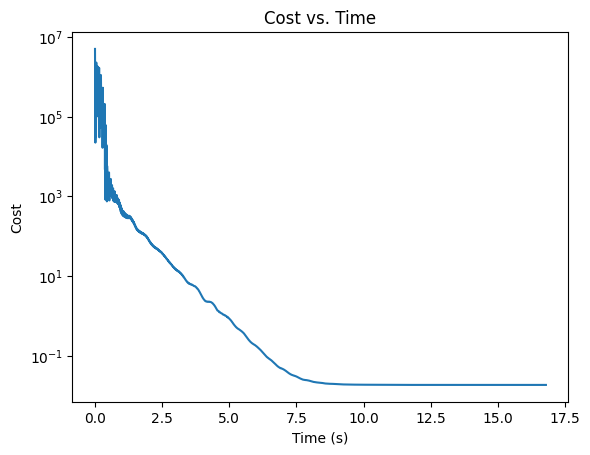

Final weights:
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 8.52786785e+00
 6.67872098e-07 0.00000000e+00]


In [118]:
learning_rate = 0.005
max_iterations = 1800
momentum_factor = 0.99 # Value between 0 and 1 for momentum acceleration
regularization_lambda = 0.001
threshold = 512
# Perform projected gradient descent with momentum
weights = projected_gradient_descent(X_train, y_train, learning_rate, max_iterations, threshold, regularization_lambda, momentum_factor)

print("Final weights:")
print(weights)
file_path = "final_weights.txt"

# Write the weights to the text file
with open(file_path, "w") as file:
    for weight in weights:
        file.write(str(weight) + "\n")
#'learning_rate': 0.005, 'threshold': 512, 'max_iterations': 3000, 'momentum_factor': 0.99, 'regularization_lambda': 0.001
# w = projected_gradient_descent(X_train, y_train, learning_rate, threshold, max_iterations, regularization, momentum)

In [119]:
y_pred = X_val.dot(weights)
mse = np.mean((y_pred - y_val) ** 2)
print(f"Test MSE: {mse}")

Test MSE: 1.3927762908987793e-08


In [120]:
def r_squared(y_true, y_pred):
    y_mean = np.mean(y_true)
    ss_total = np.sum((y_true - y_mean) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    return r2


In [121]:
# Assuming you have the true target values (y_true), predicted target values (y_pred), and weights (weights)

# Calculate the predicted target values
y_pred = X_val.dot(weights)

# Calculate the R-squared metric
accuracy = r_squared(y_val, y_pred)

print(f"Accuracy: {accuracy}")


Accuracy: 0.9999999999989073
